# EDA on Rating beauty products of amazon dataset

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
path = "./ratings_Beauty.csv"
data = pd.read_csv(path)
df = pd.DataFrame(data=data)
df.head(3)

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200


In [3]:
df.columns = ["user_id", "product_id", "rating", "time"]
df[:2]

,user_id,product_id,rating,time
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200


## Data cleaning

In [4]:
# Looking for NAN Values
df[df.isna()].any()

user_id       False
product_id    False
rating        False
time          False
dtype: bool

In [5]:
# Looking for null valus
df[df.isnull()].any()

user_id       False
product_id    False
rating        False
time          False
dtype: bool

In [6]:
df.describe()

,rating,time
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   rating      float64
 3   time        int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


there is no nan, null or outlier in our dataset

data type of int64 - Timestamp is scaled in Unix time system and i leave it as it is


# Analysis Based on Products

In [8]:
count_product = df.groupby(by="product_id").agg({"user_id" : "count", "rating" : "mean", "time": "min"})
count_product.columns = ["number_of_ratings", "average_score", "start"]
count_product.head()

,number_of_ratings,average_score,start
product_id,,,
0205616461,1,5.0,1369699200
0558925278,2,4.0,1355443200
0733001998,1,4.0,1382572800
0737104473,1,1.0,1274227200
0762451459,1,5.0,1404518400


we must look at outliers of number_of_ratings column

for having perfect decision making it is better to have a normal distribution, so i pick products with at least rated 30 times

In [9]:
count_product = count_product.loc[ count_product["number_of_ratings"] > 30]
count_product.head()

,number_of_ratings,average_score,start
product_id,,,
7806397051,35,3.285714,1346544000
9746427962,41,4.609756,1296691200
9759091062,40,3.125000,1346716800
9788071198,36,3.833333,1340582400
9788072216,34,4.529412,1316390400


time series
hypothesis testing
product histogram



## Rating prediction per product

I'd like to assess whether the data is suitable for time series analysis. If it proves suitable, I plan to employ a model to predict the quantity and average of ratings for a specific product within a relevant timeframe.

In [10]:
# lets find a product which is rated 100 times
rated700_times_product = count_product.loc[ count_product["number_of_ratings"] > 700][:1]
selected_product_id = rated700_times_product.index[0]

In [11]:
# lets find id in main data frame
product_data = df.loc[df["product_id"] == selected_product_id]
avg_rating_per_time = product_data.groupby(by="time", as_index=False).agg({"rating" : "mean", "user_id": "count"}).sort_values(by="time", ascending=True)
avg_rating_per_time.columns = ["time", "average_rating", "frequency"]
avg_rating_per_time.head(2)

,time,average_rating,frequency
0,1120867200,5.0,1
1,1126310400,5.0,1


start time of rates for this product is 1120867200 which is equal to 9 july 2005 

i will start from 1 july 2005, lets create month bins 

In [12]:
# Function to convert Unix timestamp to month
def unix_timestamp_to_month(timestamp, start_bin_timestamp):
    start_bin_date = datetime.datetime.utcfromtimestamp(start_bin_timestamp)
    target_date = datetime.datetime.utcfromtimestamp(timestamp)
    months_difference = (target_date.year - start_bin_date.year) * 12 + (target_date.month - start_bin_date.month)
    return months_difference

# Specify the start of the month bin (July 1, 2005)
start_bin_timestamp = 1117593600


avg_rating_per_time['month'] = avg_rating_per_time['time'].apply(lambda x: unix_timestamp_to_month(x, start_bin_timestamp))
avg_rating_per_time.head(3)


,time,average_rating,frequency,month
0,1120867200,5.0,1,1
1,1126310400,5.0,1,3
2,1131926400,5.0,1,5


In [13]:
condition = {"average_rating" : "mean", "frequency":"sum"}
time_average_frequency =  avg_rating_per_time.groupby(by="month", as_index=False).agg(condition)
time_average_frequency.tail(3)

,month,average_rating,frequency
83,107,4.090909,33
84,108,3.641667,32
85,109,4.666667,17


Text(0, 0.5, 'frequency')

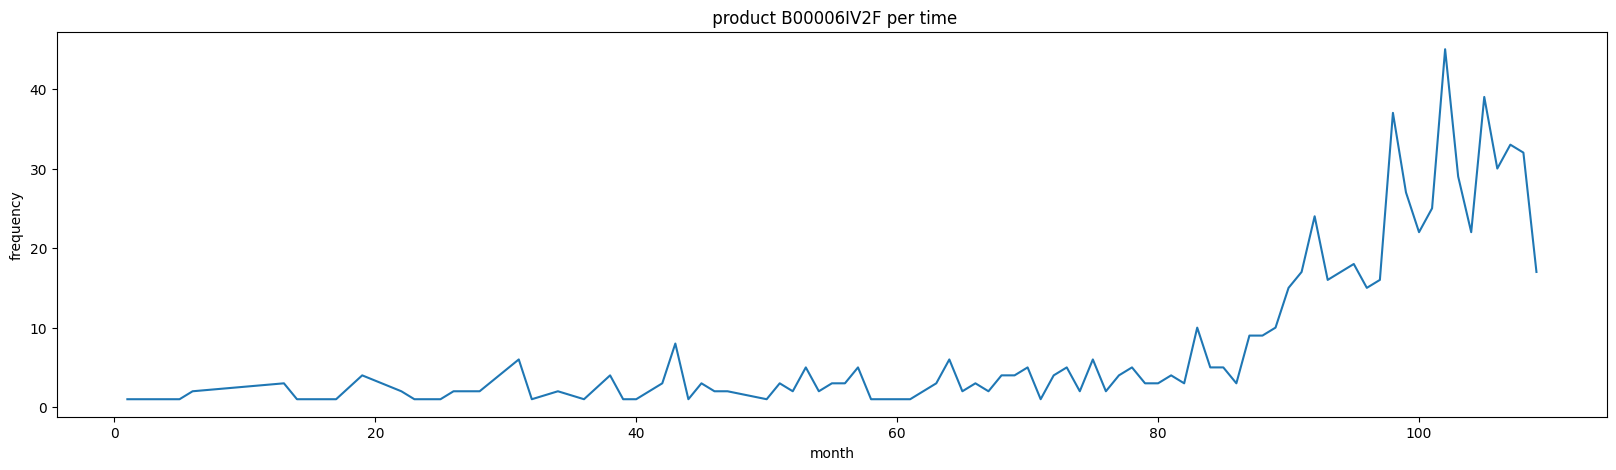

In [14]:
plt.figure(figsize = (20, 5) )
# plt.plot(avg_rating_per_time["month"], avg_rating_per_time['average_rating'])
plt.plot(time_average_frequency["month"], time_average_frequency['frequency'])
plt.title(f" product {selected_product_id} per time")
plt.xlabel("month")
plt.ylabel("frequency")


We have a dataset for time series analysis, specifically for building an ARIMA model. To prepare the data, I'll create a separate notebook dedicated to data preparation.

Through time series analysis, our goal is to predict the future number of ratings and the average rating for the upcoming month or year.

let's look the data is stationary for analysis of number of users 

# Analysis Based on Users

In [15]:
def calculate_active_time(x):
    return (x.max() - x.min()) / (30 * 24 * 3600)

def get_start_from(x):
    return pd.to_datetime(x.min(), unit='s')

def get_active_until(x):
    return pd.to_datetime(x.max(), unit='s')

### Alert: Executing the following cell will require approximately 30 minutes.


In [16]:

df['active_months'] = df.groupby('user_id')['time'].transform(calculate_active_time)
df['start_from'] = df.groupby('user_id')['time'].transform(get_start_from)
df['active_until'] = df.groupby('user_id')['time'].transform(get_active_until)


In [17]:

user_info = df.groupby(by="user_id").agg({
                            "product_id" : "count",
                            "rating" : "mean",
                            # To determine the duration of a user's activity in terms of months.
                            "active_months" : "first",
                            "start_from" : "first",
                            "active_until" : "first",
})

user_info = user_info.rename(columns={"product_id" : "number_of_ratings",
                                      "rating" : "average_rating_scores"})
user_info.head(3)

,number_of_ratings,average_rating_scores,active_months,start_from,active_until
user_id,,,,,
A00008821J0F472NDY6A2,1,5.0,0.0,2013-05-09,2013-05-09
A000186437REL8X2RW8UW,1,5.0,0.0,2014-04-10,2014-04-10
A0002574WYJMBWKNCPY8,1,3.0,0.0,2014-02-05,2014-02-05


In [18]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1210271 entries, A00008821J0F472NDY6A2 to AZZZU2TD7Q3ET
Data columns (total 5 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   number_of_ratings      1210271 non-null  int64         
 1   average_rating_scores  1210271 non-null  float64       
 2   active_months          1210271 non-null  float64       
 3   start_from             1210271 non-null  datetime64[ns]
 4   active_until           1210271 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 55.4+ MB


In [19]:
user_info.describe()

,number_of_ratings,average_rating_scores,active_months,start_from,active_until
count,1.210271e+06,1.210271e+06,1.210271e+06,1210271,1210271
mean,1.671584e+00,4.115778e+00,2.573513e+00,2012-12-09 08:18:40.473678848,2013-02-24 13:14:26.772152320
min,1.000000e+00,1.000000e+00,0.000000e+00,1998-10-19 00:00:00,1998-10-19 00:00:00
25%,1.000000e+00,3.750000e+00,0.000000e+00,2012-06-20 00:00:00,2012-11-11 00:00:00
50%,1.000000e+00,5.000000e+00,0.000000e+00,2013-05-23 00:00:00,2013-08-04 00:00:00
75%,2.000000e+00,5.000000e+00,0.000000e+00,2014-01-15 00:00:00,2014-02-23 00:00:00
max,3.890000e+02,5.000000e+00,1.651667e+02,2014-07-23 00:00:00,2014-07-23 00:00:00
std,2.531884e+00,1.286298e+00,9.080760e+00,NaN,NaN


In [20]:
len(user_info.index.unique())

1210271

**This dataset comprises 1.2 million (1,210,271) users, with ratings ranging from 1 to 5. The number of ratings per user varies between 1 and 389, ensuring a robust dataset with high data quality.**

# Conclusion

**Strengths:**

1. The dataset exhibits remarkable cleanliness, with no instances of null, NAN, or duplicated values, contributing to its reliability and ease of analysis.

2. The temporal structure of the dataset makes it exceptionally well-suited for time series analysis, allowing for the exploration of trends and patterns over a specific period.

3. The dataset is highly conducive to RFM (Recency, Frequency, Monetary) analysis, offering valuable insights into customer behavior and segmentation.

**Weaknesses:**

1. The primary drawback lies in the dataset's age, spanning from 2000 to 2014, indicating a need for an update to incorporate more recent information and align with contemporary trends.

2. A significant weakness arises from the lack of defined attributes such as product names, product categories, owner's country/city, and user information. This limitation renders the dataset unsuitable for tasks related to product pricing, as the essential details for such analyses are not present. Addressing this deficiency would enhance the dataset's usability across a broader spectrum of analytics.